Comenzamos la red neuronal haciendo los imports pertinentes que nos seannecesarios para todo el proyecto, además aprovechamos para importar nuestro dataset con el que entrenará la neurona para distinguir entre frutsas.

In [1]:
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

100%|██████████| 964M/964M [00:12<00:00, 84.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


Lo que hacemos en esta parte es realizar las transformaciones para el set de imagenes que van a ser entrenadas para añadir más imagenes.

Además definimos las variales par separar el dataset en dos grupos:

    . train_size: Le otorgamos el 80% del dataset para su entrenamiento.
    . test_size:  El 20% restante será utilizado para su testeo.
Luego definimos los Dataloaders y guardamos los valores en variables.

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),                                                  # Resize
    transforms.Lambda(lambda img: img.convert("RGB")),                              # Eliminamos las transparencias
    transforms.RandomHorizontalFlip(),                                              # Volteo horizontal aleatorio
    transforms.RandomRotation(degrees=30),                                          #  Rotación aleatoria entre -30 y 30 grados
    transforms.RandomCrop(128, padding=4),                                          # Recorte aleatorio con relleno de 4 píxeles
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Ajustes de brillo, contraste, saturación y tono
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),                       # Traslación aleatoria
    transforms.ToTensor(),                                                          # Convertimos la imagen a Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])                                     # Normalizar imágenes en escala de grises
])

train_path = os.path.join(path,"fruits-360_dataset_original-size","fruits-360-original-size", "Training")
dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

# Dividir datos en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Guardar en variables
train = train_loader
test = test_loader
# Verificar que las imágenes tienen el tamaño adecuado
for images, labels in train_loader:
    print("Tamaño de las imágenes (entrenamiento):", images.shape)
    break

for images, labels in test_loader:
    print("Tamaño de las imágenes (prueba):", images.shape)
    break
print("Datos de entrenamiento y prueba listos")

Tamaño de las imágenes (entrenamiento): torch.Size([64, 3, 128, 128])
Tamaño de las imágenes (prueba): torch.Size([64, 3, 128, 128])
Datos de entrenamiento y prueba listos


Definimos las redes convulativas, esta va a constar de lo siguiente:

      . Tres capas convolutivas
      . En la primera definimos el valor 3 en el canal de entrada, esto se debe a que sus imágenes son RGB.
      . Definímos también su valor de MaxPool, esto lo que hará será reducir el ancho y el alto de los tensores
      . Con el valor 64 vemos que funciona bien el entrenamiento.
  
Con 64 a la salida vemos que su eficiencia mejora de manera bastante buena, para llegar a este valor estuvimos realizando varias pruebas para evitar el sobreajuste, es cierto que a cuantas menos neuronas menos características de las imágenes se aprende para su clasificación, pero también evitamos sobreajustes.

In [3]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=24):
        super(ConvNet, self).__init__()

        # Primera capa convolutiva
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolutiva
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        # Tercera capa convolutiva
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        # Capa completamente conectada
        self.fc1 = nn.Linear(128 * 16 * 16, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Primera capa convolutiva
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Reduce de 32x32 a 16x16

        # Segunda capa convolutiva
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Reduce de 16x16 a 8x8

        # Tercera capa convolutiva
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Reduce de 8x8 a 4x4

        # Aplanamos las dimensiones
        x = x.view(x.size(0), -1)

        # Capa completamente conectada
        x = self.bn_fc1(self.fc1(x))
        x = F.relu(x)
        x = self.dropout(x)

        # Capa de salida
        x = self.fc2(x)

        return x


En este caso lo que vamos a comprobar es si tenemos CUDA disponible para ala ejecución pero si no haremos uso de la CPU y enviamos aesto al dispositivo donde verdaderamente se ejecute, esto lo hacemos para ver si tenemos un dispositivo más rapido donde se pudiera ejecutar de una manera más optima.

In [4]:
# Verificar si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover el modelo al dispositivo adecuado
model = ConvNet().to(device)

Visualizaremos el priemr lote para ver la forma que tiene el tensor, esto lo haremos para ver los siguentes datos:

        .{"batch_size","número de canales","alto_imágen","ancho_imágen"}

Su utilidad en el cálculo será para comprobar como queda la imágen tras actualizar ser actualizados por las capas convolutivas.

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Inspeccionar el primer lote
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Forma del tensor: {images.shape}")

Forma del tensor: torch.Size([64, 3, 128, 128])


 Realizando busquedas sobre que valor de epoch(epocas) sería el más optimo para entrenar la red neuronal decidimos hacer uso de un valor de 10.

  Esto lo decidimos haciendo uso del  criterio de **"Cross-entropy y optimizador de Adam"**

* **Criterio cross-entropy:**
        . El criterio de Cross-Entropy Loss (o pérdida de entropía cruzada)
        es una función de pérdida comúnmente utilizada en problemas de clasificación,
        especialmente en clasificación multiclase.
        . Su propósito es comparar la probabilidad predicha por la red con la etiqueta real.

* Optimizador de Adam:

        . El optimizador de Adam es un método
          de optimización eficiente y ampliante
          usado en redes neuronales profundas.

In [6]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Inicializar listas para guardar estadísticas
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Entrenamiento
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Modo entrenamiento
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Guardar estadísticas de entrenamiento
    train_loss = running_loss / len(train_loader)  # Asegurarse de calcular antes del print
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluación en modo validación
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Guardar estadísticas de validación
    val_loss /= len(test_loader)  # Asegurarse de calcular antes del print
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Mostrar estadísticas por época
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 2.2870, Train Accuracy: 37.18%, Val Loss: 1.6704, Val Accuracy: 55.65%
Epoch 2/10, Train Loss: 1.5543, Train Accuracy: 55.90%, Val Loss: 1.2878, Val Accuracy: 62.07%
Epoch 3/10, Train Loss: 1.2302, Train Accuracy: 64.07%, Val Loss: 0.9436, Val Accuracy: 74.58%
Epoch 4/10, Train Loss: 0.9942, Train Accuracy: 69.90%, Val Loss: 0.7778, Val Accuracy: 78.83%
Epoch 5/10, Train Loss: 0.8425, Train Accuracy: 73.82%, Val Loss: 0.7320, Val Accuracy: 75.78%
Epoch 6/10, Train Loss: 0.7512, Train Accuracy: 76.14%, Val Loss: 0.6850, Val Accuracy: 78.59%
Epoch 7/10, Train Loss: 0.7127, Train Accuracy: 76.59%, Val Loss: 0.5657, Val Accuracy: 82.60%
Epoch 8/10, Train Loss: 0.6094, Train Accuracy: 80.04%, Val Loss: 0.4581, Val Accuracy: 86.69%
Epoch 9/10, Train Loss: 0.5293, Train Accuracy: 83.17%, Val Loss: 0.4183, Val Accuracy: 87.25%
Epoch 10/10, Train Loss: 0.4941, Train Accuracy: 84.11%, Val Loss: 0.3943, Val Accuracy: 87.01%


Como se puede observar en esta captura, realizamos una prueba con tres neuronas, como se puede observar la neurona está sobreestimando debido a que más que aprender lo que está haciendo es memorizar, se puede observar en la parte de "Val Accuracy" vemos que alcanza valores muy altos en épocas muy tempranas.

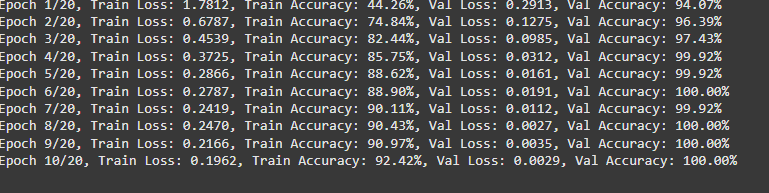

Observamos cual es la precisión del modelo entrenado para saber cual es su efectividad tras el entrenamiento de la red neuronal.

In [7]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on test images: {100 * correct / total}%')

Accuracy of the model on test images: 87.57016840417%


En esta parte de código lo que haremos será representar de manera gráfica los valores calculados antes, esto nos va a servir bastante para saber si por ejemplo la neurona está sobreajustandose en vez de estar verdaderamente aprendiendo.

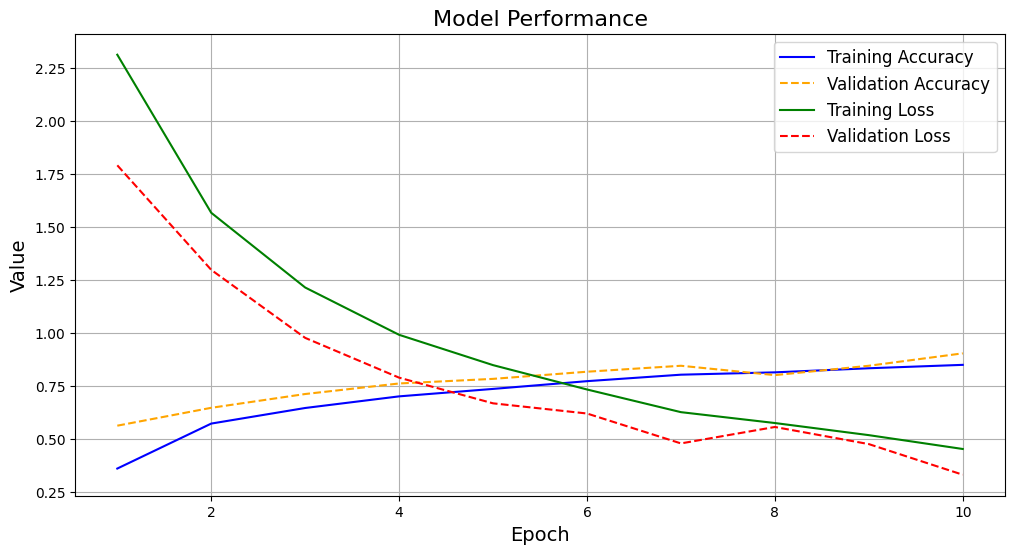

In [ ]:
# Supongamos que tienes las listas train_accuracies, val_accuracies, train_losses, val_losses definidas
epochs_range = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 6))

# Graficar la precisión (entrenamiento y validación)
plt.plot(epochs_range, [acc / 100 for acc in train_accuracies], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(epochs_range, [acc / 100 for acc in val_accuracies], label='Validation Accuracy', color='orange', linestyle='--')

# Graficar la pérdida (entrenamiento y validación)
plt.plot(epochs_range, train_losses, label='Training Loss', color='green', linestyle='-')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red', linestyle='--')

# Configurar el gráfico
plt.title('Model Performance', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)

# Mostrar el gráfico
plt.show()

Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Error en la predicción: True: 6, Pred: 5
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Error en la predicción: True: 10, Pred: 8
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Error en la predicción: True: 1, Pred: 11
Numero de imagenes correctas: 56
Error en la predicción: True: 2, Pred: 1
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Numero de imagenes correctas: 56
Error en la predicción: True: 17, Pred: 18

KeyboardInterrupt: 

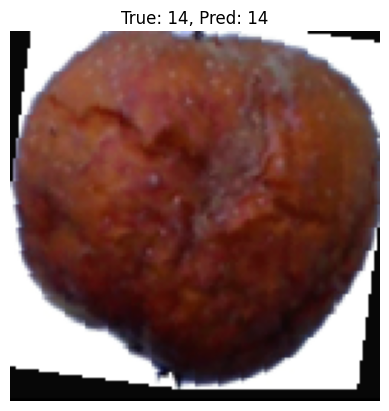

In [9]:
model.eval()
correct = 0
total = 0

k = 1  # Mostrar una imagen cada k imágenes en el conjunto de test

with torch.no_grad():                                                 # Deshabilitar gradientes
    for batch_idx, (images, labels) in enumerate(test_loader):
        outputs = model(images)                                       # Predicciones
        _, predicted = torch.max(outputs.data, 1)                     # Clase predicha
        total += labels.size(0)                                       # Total de muestras
        correct += (predicted == labels).sum().item()                 # Acertadas

        # Mostrar una imagen cada k imágenes
        if batch_idx % k == 0:                                        # Cada k iteraciones
            for i in range(images.size(0)):
                image = images[i]                                     # Imagen individual
                label = labels[i]                                     # Etiqueta verdadera
                pred = predicted[i]                                   # Predicción del modelo
                image = image * 0.5 + 0.5                             # Deshacer la normalización
                image_np = image.permute(1, 2, 0).numpy()

                # Mostrar la imagen con la comparación entre la etiqueta y la predicción
                plt.imshow(image_np)
                plt.title(f'True: {label.item()}, Pred: {pred.item()}')
                plt.axis('off')
                if pred != label:
                    print(f'Error en la predicción: True: {label.item()}, Pred: {pred.item()}')
                    #plt.show()
                else:
                    print(f'Numero de imagenes correctas: {correct}')
